In [4]:
import vispy
print(vispy.sys_info())

RFBOutputContext()

Platform: Windows-10-10.0.22621-SP0
Python:   3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
NumPy:    1.26.2
Backend:  jupyter_rfb
pyqt4:    None
pyqt5:    ('PyQt5', '5.15.10', '5.15.2')
pyqt6:    None
pyside:   None
pyside2:  None
pyside6:  None
pyglet:   None
glfw:     None
sdl2:     None
wx:       None
egl:      None
osmesa:   None
tkinter:  None
jupyter_rfb: jupyter_rfb
_test:    None

GL version:  '4.6.0 NVIDIA 536.25'
MAX_TEXTURE_SIZE: 32768
Extensions: 'GL_AMD_multi_draw_indirect GL_AMD_seamless_cubemap_per_texture GL_AMD_vertex_shader_viewport_index GL_AMD_vertex_shader_layer GL_ARB_arrays_of_arrays GL_ARB_base_instance GL_ARB_bindless_texture GL_ARB_blend_func_extended GL_ARB_buffer_storage GL_ARB_clear_buffer_object GL_ARB_clear_texture GL_ARB_clip_control GL_ARB_color_buffer_float GL_ARB_compatibility GL_ARB_compressed_texture_pixel_storage GL_ARB_conservative_depth GL_ARB_compute_shader GL_ARB_compute_variable_group_size GL_

RFBOutputContext()

CanvasBackend(css_height='5120px', css_width='5120px')
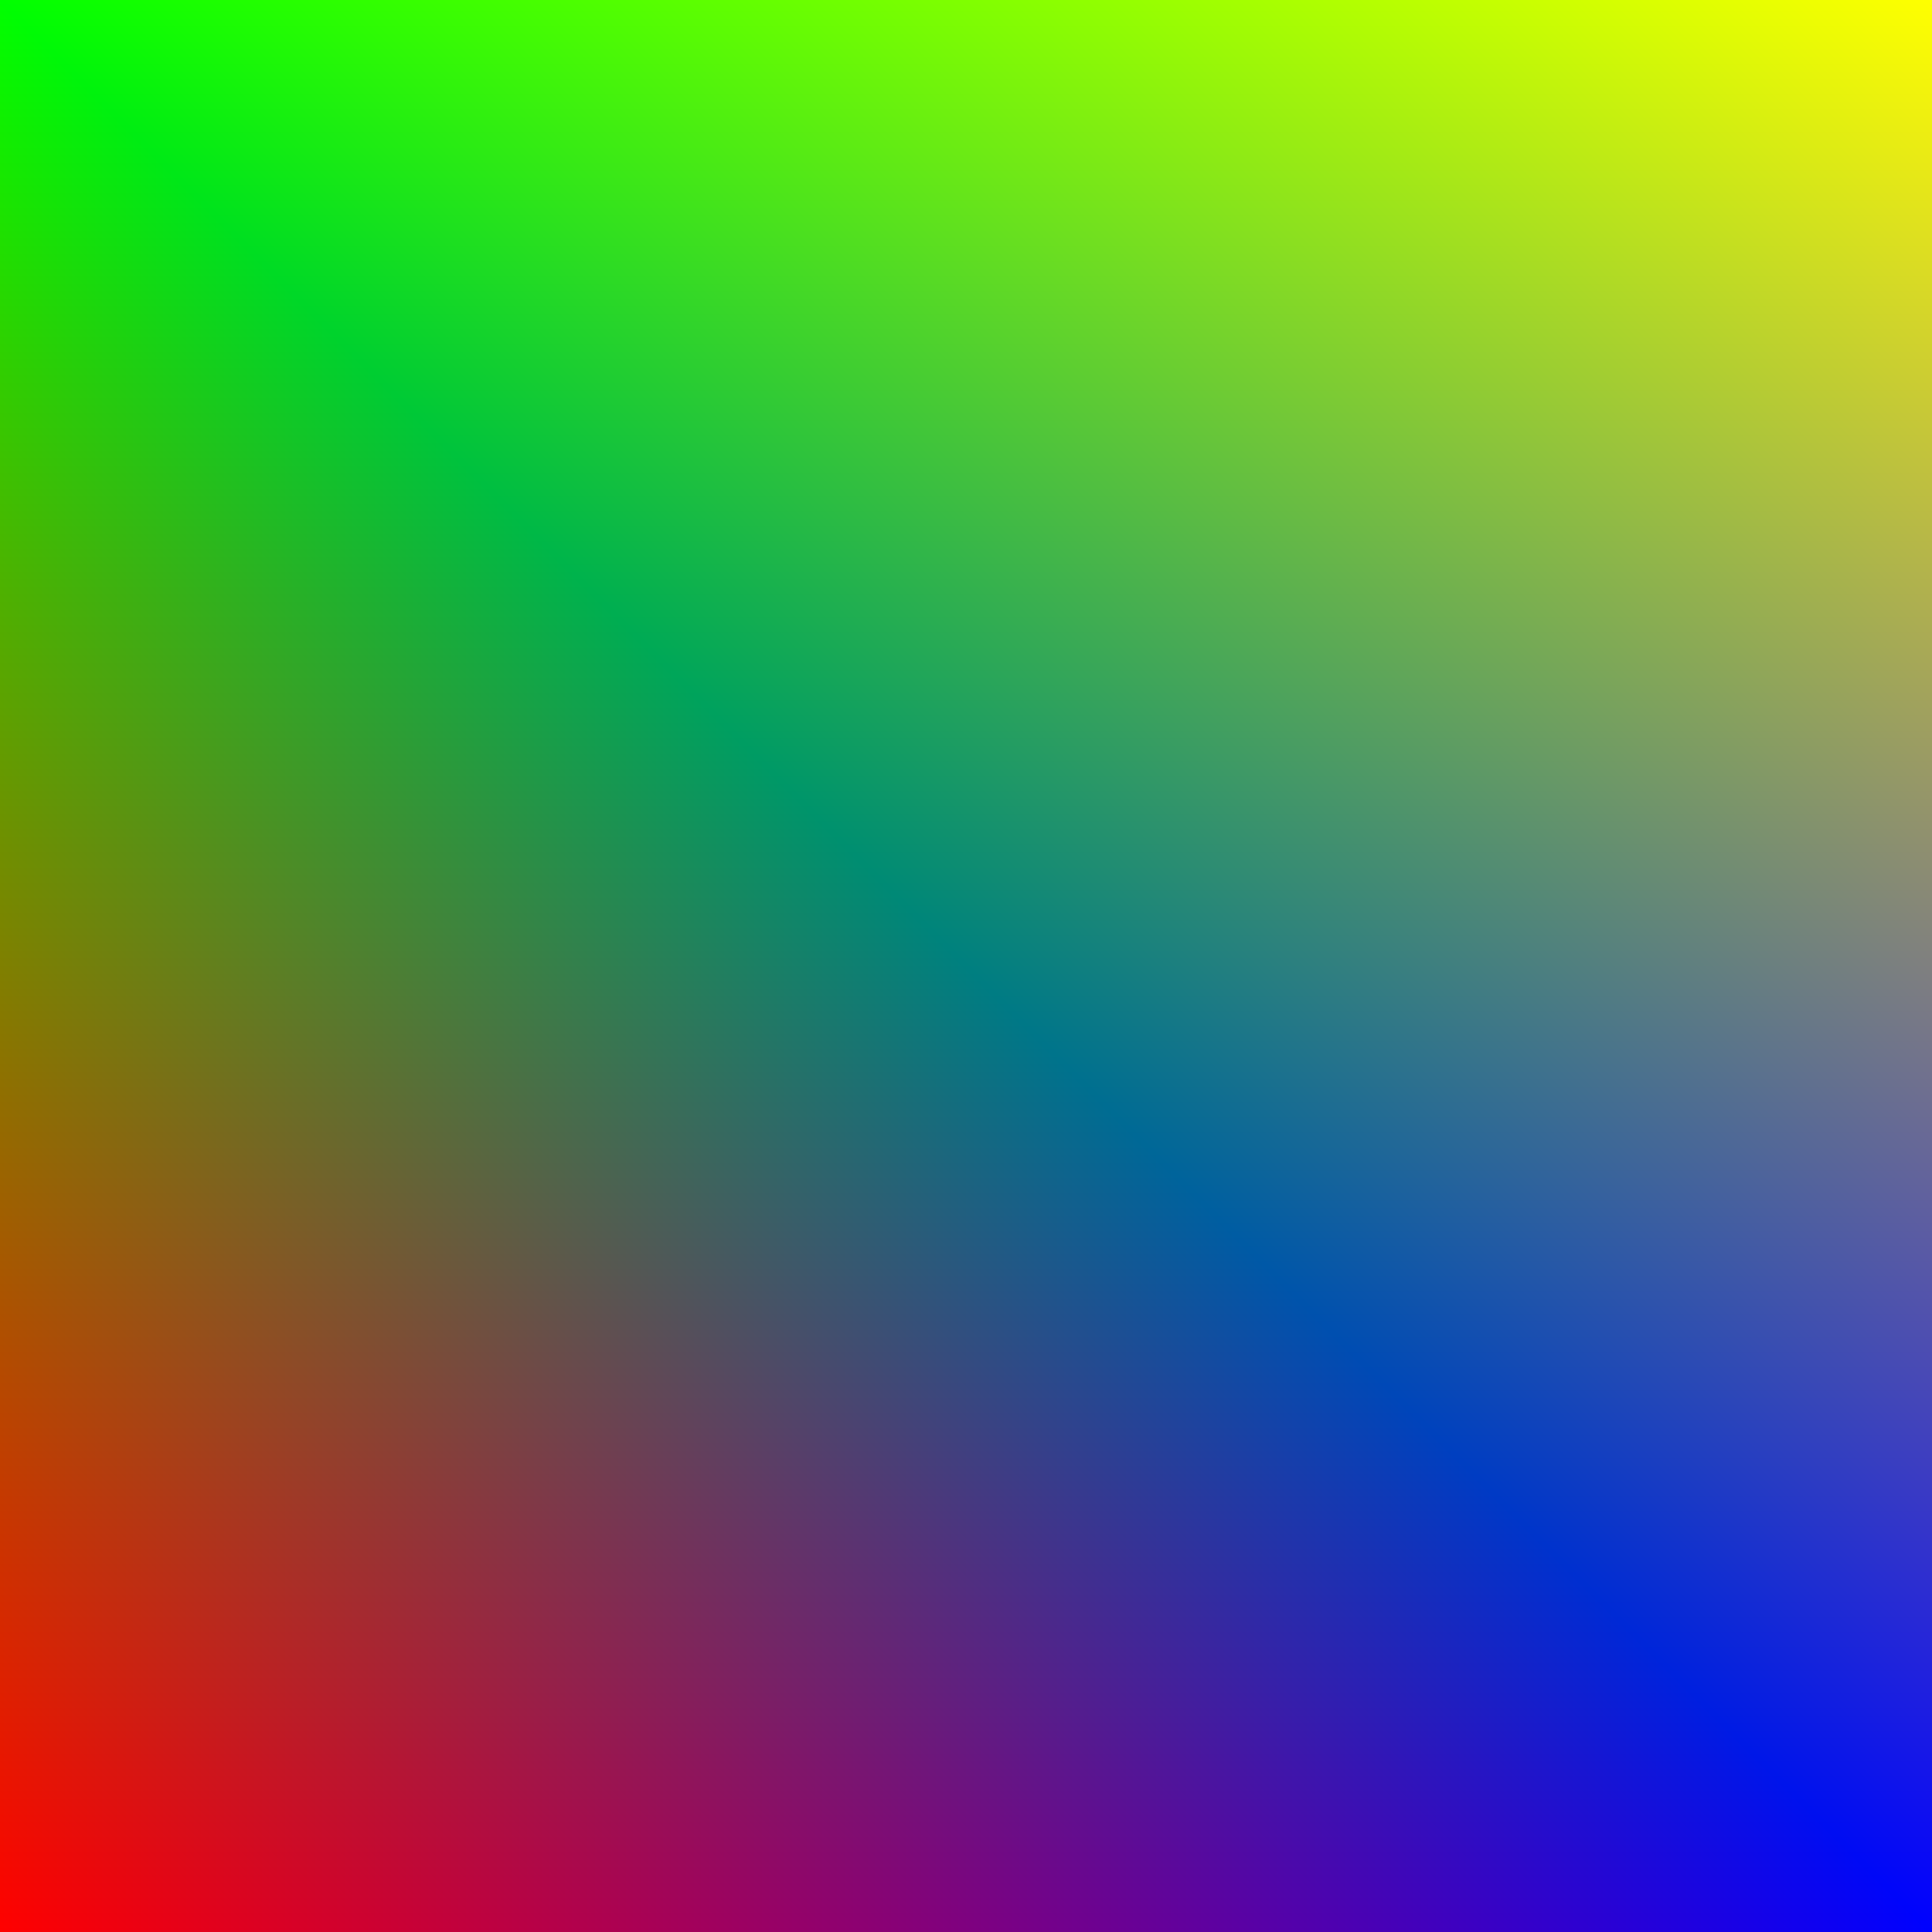

In [94]:
from vispy import app, gloo
from vispy.gloo import Program
from vispy.gloo.util import _screenshot

vertex = """
    attribute vec4 color;
    attribute vec2 position;
    varying vec4 v_color;
    void main()
    {
        gl_Position = vec4(position, 0.0, 1.0);
        v_color = color;
    } """

fragment = """
    varying vec4 v_color;
    void main()
    {
        gl_FragColor = v_color;
    } """


class Canvas(app.Canvas):
    def __init__(self):
        super().__init__(size=(5120, 5120), title='Colored quad',
                         keys='interactive')

        # Build program
        self.program = Program(vertex, fragment, count=4)

        # Set uniforms and attributes
        self.program['color'] = [(1, 0, 0, 1), (0, 1, 0, 1),
                                 (0, 0, 1, 1), (1, 1, 0, 1)]
        self.program['position'] = [(-1, -1), (-1, +1),
                                    (+1, -1), (+1, +1)]

        gloo.set_viewport(0, 0, *self.physical_size)

        self.show()

    def on_draw(self, event):
        gloo.clear()
        self.program.draw('triangle_strip')

    def on_resize(self, event):
        gloo.set_viewport(0, 0, *event.physical_size)

c = Canvas()
c

In [96]:
img=c.render('triangle_strip')
vispy.io.image.write_png("vispy.png", img)

In [71]:
button = ipywidgets.ToggleButton(value=False, description="Export")
c = Canvas()

def on_click(change):
    print("Hello")
    img=c.program.draw('triangle_strip')
    vispy.io.image.write_png("vispy.png", img)
    
img=c.program.render('triangle_strip')
vispy.io.image.write_png("vispy.png", img)
c


RFBOutputContext()

AttributeError: 'Program' object has no attribute 'render'

In [21]:
import numpy as np
import ipywidgets
import jupyter_rfb

In [85]:
class SimpleRFB(jupyter_rfb.RemoteFrameBuffer):
   
    green_value = 200
    
    def get_frame(self):
        a = np.zeros((100, 100, 3), np.uint8)
        a[10:-10,10:-10,1] = self.green_value
        return a   

    def get_Export(self):
        a = np.zeros((10000, 10000, 3), np.uint8)
        a[1:-1,1:-1,1] = self.green_value
        return a   

In [86]:
slider = ipywidgets.IntSlider(min=50, max=255, value=200)
button = ipywidgets.ToggleButton(value=False, description="Export")
rfb = SimpleRFB()

def on_slider_change(change):
    rfb.green_value = change["new"]
    rfb.request_draw()

def on_click(change):
    print("Hello")
    img=rfb.get_Export()
    vispy.io.image.write_png("vispy.png", img)

button.observe(on_click)
slider.observe(on_slider_change, names='value')
ipywidgets.HBox([rfb, slider,button])

RFBOutputContext()

In [ ]:
# https://github.com/10mrohit/floyd-steinberg-dithering
from math import floor
from PIL import Image

import os


class Dither():
    def __init__(self, path, algorithm=None, output=None):
        self.path = self.get_path(path)
        self.algorithm = algorithm
        self.output = output
        self.func = self.get_func(self.algorithm)
        self.func(self.path)

    def get_path(self, path):
        if path.startswith('/') and not path.startswith('~/'):
            return os.getcwd() + '/' + path
        else:
            return path

    def get_func(self, algorithm):
        return self.floyd_steinberg_dither

    def apply_threshold(self, value):
        return 255 * floor(value/128)

    def floyd_steinberg_dither(self, image_file):
        new_img = Image.open(image_file)

        new_img = new_img.convert('RGB')
        pixel = new_img.load()

        x_lim, y_lim = new_img.size

        for y in range(1, y_lim):
            for x in range(1, x_lim):
                red_oldpixel, green_oldpixel, blue_oldpixel = pixel[x, y]

                red_newpixel = self.apply_threshold(red_oldpixel)
                green_newpixel = self.apply_threshold(green_oldpixel)
                blue_newpixel = self.apply_threshold(blue_oldpixel)

                pixel[x, y] = red_newpixel, green_newpixel, blue_newpixel

                red_error = red_oldpixel - red_newpixel
                blue_error = blue_oldpixel - blue_newpixel
                green_error = green_oldpixel - green_newpixel

                if x < x_lim - 1:
                    red = pixel[x+1, y][0] + round(red_error * 7/16)
                    green = pixel[x+1, y][1] + round(green_error * 7/16)
                    blue = pixel[x+1, y][2] + round(blue_error * 7/16)

                    pixel[x+1, y] = (red, green, blue)

                if x > 1 and y < y_lim - 1:
                    red = pixel[x-1, y+1][0] + round(red_error * 3/16)
                    green = pixel[x-1, y+1][1] + round(green_error * 3/16)
                    blue = pixel[x-1, y+1][2] + round(blue_error * 3/16)

                    pixel[x-1, y+1] = (red, green, blue)

                if y < y_lim - 1:
                    red = pixel[x, y+1][0] + round(red_error * 5/16)
                    green = pixel[x, y+1][1] + round(green_error * 5/16)
                    blue = pixel[x, y+1][2] + round(blue_error * 5/16)

                    pixel[x, y+1] = (red, green, blue)

                if x < x_lim - 1 and y < y_lim - 1:
                    red = pixel[x+1, y+1][0] + round(red_error * 1/16)
                    green = pixel[x+1, y+1][1] + round(green_error * 1/16)
                    blue = pixel[x+1, y+1][2] + round(blue_error * 1/16)

                    pixel[x+1, y+1] = (red, green, blue)

        if self.output:
            new_img.save(self.output)
        else:
            new_img.show()

In [ ]:
Dither("vispy2.png")